<a href="https://colab.research.google.com/github/yubinvip/Hung-yi-Lee-AI2024/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4: Become an AI Hypnosis Master
Objectives:
- Understand how various prompts affect the performance of a Large Language Model.
- Design a prompt that improves Gemini's accuracy in solving mathematical problems.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to ntu-gen-ai-2024-spring-ta@googlegroups.com

##  Preparing Section

### Install all necessary packages.
- This process will take about **30** seconds.


In [ ]:
!pip install tqdm jinja2 gradio==3.50.0
!pip install -q -U google-generativeai

### Import all necessary packages and set up your **Gemini API Key**.


In [ ]:
from tqdm import tqdm
import jinja2
import pickle, json, os, time, re
import traceback
import google.generativeai as genai
# TODO: Enter your Gemini API key
#@title Set your Gemini API Key.
GOOGLE_API_KEY = "" #@param {type:"string"}
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

# Check if you have set your Gemini API successfully
# You should see "Set Gemini API sucessfully!!" if nothing goes wrong.
try:
    model.generate_content(
      "test",
    )
    print("Set Gemini API KEY sucessfully!!")
except:
    print("There seems to be something wrong with your Gemini API. Please follow our demonstration in the slide to get a correct one.")

Set Gemini API KEY sucessfully!!


### Set up Gemini API !

* Here, we set up Gemini API! using the version `gemini-pro`.


In [ ]:
class GeminiModel():
    def __init__(self, cache_file="gemini_cache"):
      # Constructor to initialize the OpenAIModel object.
      # cache_file: Name of the file used for caching data.
      self.cache_file = cache_file
      # Load the cache from the file.
      self.cache_dict = self.load_cache()

      ## count token
      #tokens = my_model.model.count_tokens("Hello world")
      #token = tokens.total_token

      # init model
      safety_settings = [
          {
              "category": "HARM_CATEGORY_DANGEROUS",
              "threshold": "BLOCK_NONE",
          },
          {
              "category": "HARM_CATEGORY_HARASSMENT",
              "threshold": "BLOCK_NONE",
          },
          {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "threshold": "BLOCK_NONE",
          },
          {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "threshold": "BLOCK_NONE",
          },
          {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "threshold": "BLOCK_NONE",
          },
      ]
      self.model = genai.GenerativeModel('gemini-pro', safety_settings=safety_settings)
      # self.model = genai.GenerativeModel('gemini-pro')

    def save_cache(self):
      # Save the current state of the cache to the cache file.
        with open(self.cache_file, "wb") as f:
            pickle.dump(self.cache_dict, f)

    def load_cache(self, allow_retry=True):
        # Load the cache from the cache file, with retry logic for handling read errors.
        if os.path.exists(self.cache_file):
            while True:
                try:
                    with open(self.cache_file, "rb") as f:
                        cache = pickle.load(f)
                    break
                except Exception:
                    if not allow_retry:
                        assert False
                    print ("Pickle Error: Retry in 5sec...")
                    time.sleep(5)
        else:
            # Initialize the cache if the file does not exist.
            cache = {}
        return cache

    def set_cache_file(self, file_name):
      self.cache_file = file_name
      # Load the cache from the file.
      self.cache_dict = self.load_cache()

    def get_completion(self, content):
        # Get a completion for a given content, optionally using the extraction tool.
        # Checks cache before making a new request to the model.
        if content in self.cache_dict:
            return self.cache_dict[content]
        for _ in range(3):
            try:
              # Make a request to the Gemini model.

              response = self.model.generate_content(
                      content,
                      generation_config=genai.types.GenerationConfig(temperature=1.0),
                      request_options={"timeout": 120}
                  )
              # Store the completion
              completion = response.text
              self.cache_dict[content] = completion
              return completion
            except Exception as e:
                # traceback.print_exc()
                print(e, "\n")
                time.sleep(1)
        return None

    ## need double check
    def is_valid_key(self):
        for _ in range(4):
            try:
                # ref: https://ai.google.dev/tutorials/python_quickstart
                response = self.model.generate_content(
                        "hi there",
                        generation_config=genai.types.GenerationConfig(temperature=1.0)
                    )
                return True
            except Exception as e:
                traceback.print_exc()
                time.sleep(1)
        return False

    def prompt_token_num(self, prompt):
        tokens = self.model.count_tokens(prompt)
        token = tokens.total_tokens

        ## DEBUG
        #print(f"The token num of \'{prompt}\' is {token}")

        return token

    def two_stage_completion(self, question, content):
        # A two-stage completion process: first to get the rationale and then the final answer.
        rationale = self.get_completion(content)
        if not rationale:
            return {
            'prompt': content,
            'rationale': None,
            'answer': None
            }

        ans = self.get_completion(content = f"Q:{question}\nA:{rationale}\nThe answer to the original question is (a number only): ")
        return {
            'prompt': content,
            'rationale': rationale,
            'answer': ans
        }

my_model = GeminiModel()

### Questions for evaluating your prompt.
- We provide 30 questions for evaluating your prompt: [Link](https://docs.google.com/spreadsheets/d/1IehN_Qx40wPcreVE5UorTQz-puCI8NbNDQEMvcuaZcs/edit?hl=zh-tw#gid=0)
- Running this block is necessary to set all questions and answers. If you do not run this block, you will not be able to access the questions in subsequent blocks.  
- **Do not modify this block !**

In [ ]:
questions = ['An artist is creating a large mosaic using square tiles. The mosaic is designed to be a square itself and to contain exactly 3 times as many blue tiles as red tiles. If the artist has only 57 red tiles, how many tiles in total will be used to construct the complete mosaic?',
 'A farmer is filling baskets with apples for a local market. He has 120 apples and wants to distribute them evenly among his baskets. If he decides to keep 15 apples for his family and each basket can hold no more than 7 apples, what is the minimum number of baskets he needs to use for the market?',
 'A garden has rectangular plots arranged in such a way that each plot shares sides with exactly two other plots, forming a straight line. There are 5 plots in total. Each of the middle plots has an area of 24 square meters, and the width of the plots is 4 meters. The width remains constant for all plots. The first plot in the line is twice as long as a middle plot, and the last plot is half as long as a middle plot. What is the total area of all the plots combined?',
 "A farmer's market sells apples in two types of mixed bags: Type A contains 4 red apples and 6 green apples, and Type B contains 8 red apples and 4 green apples. A customer purchases one bag of each type. What is the probability that a randomly picked apple from the collection of apples in both bags will be a green apple? Express your answer as a decimal rounded to the nearest hundredth.",
 'A gardener is planting flowers in a pattern: two red flowers followed by one yellow flower. If the gardener wants to maintain this pattern and has 35 spaces in a row to fill, how many red flowers will the gardener plant?',
 'Jason is training for a marathon and runs a certain distance each day. On Monday, he runs 5 miles. Each day after, he increases his distance by 10%. If Jason continues this pattern, how many miles will he run on Friday?',
 'In a triangular garden bed, there are 16 plants along each side. Each plant requires a circular space with a radius of 0.5 meters to grow properly. Assuming plants are placed exactly next to each other, without overlapping, and maintaining a straight line from one corner of the triangular bed to the other, how much linear meter space is used by plants along one side of the garden bed?',
 'Dr. Wilson is planting a geometric garden with flowers arranged in concentric rings around a central fountain. Each outer ring has 6 more flowers than the inner one, forming a hexagonal pattern. The innermost ring has 6 flowers. If Dr. Wilson plants enough flowers to form 15 rings, including the innermost ring, what is the total number of flowers needed for the garden?',
 'A small library is reorganizing its collection. They have a total of 120 books to distribute equally among 5 shelves. The top shelf can only bear a load of books equal to half the weight supported by the bottom shelf. If the top shelf holds 15 pounds of books and the other shelves can each hold twice as much weight, how many pounds can the bottom shelf hold?',
 'A recipe for a batch of cookies requires 3 cups of flour, 2 cups of sugar, and 1 cup of chocolate chips. If Max wants to make a triple batch but only has 4 cups of sugar, how many more cups of sugar does he need?',
 'A pet store owner is making custom birdhouses. Each birdhouse requires 0.75 liters of wood varnish for the exterior. If the owner has a 10-liter can of wood varnish, how many birdhouses can he finish before needing more varnish?',
 'A farm has chickens and cows. If there are a total of 30 heads and 88 legs, how many cows are on the farm?',
 "A local library is organizing a book fair where they sell used books to raise funds for new acquisitions. They sell 120 children's books for $2 each, 75 novels for $3 each, and twice as many magazines as novels at $1.50 each. They also sell bookmarks at $0.50 each. If they sell as many bookmarks as the total number of books and magazines sold, how much money does the library raise in total?",
 'A local farmer is preparing mixed fruit baskets using apples, oranges, and bananas. Each basket must contain 3 apples, 5 oranges, and 2 bananas. The apples are sold at $0.50 each, oranges at $0.30 each, and bananas at $0.25 each. If the farmer prepares 120 baskets for a local market and sells each basket for $5.00, how much profit will the farmer make after selling all the baskets?',
 'Maria has 24 apples and wants to divide them equally among her 6 friends. If each friend also gives 2 apples to their teacher, how many apples will each friend have left?',
 'Lila is planning a garden and wants to plant three types of flowers: daisies, tulips, and roses. She wants twice as many daisies as tulips and three times as many tulips as roses. If she plants a total of 60 flowers, how many roses is she planning to plant?',
 'A garden has three types of flowering plants. The first type has 12 flowers each, the second type has 8 flowers each, and the third type has 15 flowers each. If there are twice as many first-type plants as second-type plants and half as many third-type plants as first-type plants, and the garden has a total of 16 second-type plants, how many flowers are there in the garden?',
 "In a certain board game, transferring from one square to another costs as many coins as the number of the square you're landing on. The first square is number 1, the second square is number 2, and so on in numerical order. If a player transfers from square 5 to square 9 in one move, then to square 14 in the next, and finally to square 20, how many coins have they spent in total?",
 "A landscaping company plants trees in two parks. In Park A, they plant 5 rows of trees with 6 trees in each row. Park B is smaller, so they plant 3 rows with 7 trees in each row. However, 4 trees in Park B don't survive and must be removed. How many trees are left in total after the removals?",
 'Dr. Euler is planning a math tournament and decides to arrange the participants in groups. Each group must have the same number of participants to ensure fairness. If Dr. Euler can choose to arrange them in groups of either 4, 5, or 6, and he knows there are fewer than 100 participants, what is the largest number of participants that he can have to ensure he has no one left over no matter how he arranges the groups?',
 'A farmer has allocated a section of his land to grow pumpkins for the Halloween season. He plants 8 rows of pumpkin plants, with each row containing 15 pumpkin plants. Each pumpkin plant yields an average of 3 pumpkins. After harvest, the farmer sells 20% of the pumpkins to a local market and the rest at his farm stand. If each pumpkin sells for $4, how much total revenue does the farmer make from pumpkin sales?',
 'A triangular park ABC has trees planted along its edges. The number of trees planted on edge AB is equal to the length of edge BC, the number of trees on edge BC is equal to the length of edge CA, and the number of trees on edge CA is equal to the length of edge AB. If the lengths of edges AB, BC, and CA (in meters) form a geometric progression whose common ratio is 2, and the total number of trees planted is 77, find the length of edge AB.',
 'A group of friends are collecting cans for recycling. Maya collected twice as many cans as Liam. Liam collected 15 cans. If Zoe collected 5 more cans than Maya and the group wants to divide the total number of cans equally between 4 charities, how many cans will each charity receive?',
 "In a science competition, each team needs to build a model rocket. There are 6 teams and each team requires 1 set of materials. A set of materials includes the body tube, the engine, and the parachute. The body tube costs $12.50 each, the engine costs $18.75 each, and the parachute costs $6.25 each. After purchasing the materials for all teams, the total cost was $225. How much did the materials for one team's rocket cost?",
 'Emily has a small vegetable garden where she grows tomatoes, carrots, and cucumbers. She has twice as many tomato plants as cucumber plants, and 5 fewer carrot plants than tomato plants. If Emily has 4 cucumber plants, how many vegetable plants does she have in total?',
 'In a small village, the local tailor makes coats and trousers. He uses 3 yards of fabric for a coat and 2 yards for a pair of trousers. He has received an order for a theater production that requires twice as many trousers as coats, and the production has asked for 4 coats. If fabric costs $15 per yard, how much will the production spend on fabric for this order?',
 "A town's population grows at a constant rate. If the town's population was 5,000 in the year 2010 and 8,000 in the year 2020, what will the town's population be in the year 2025 if the growth trend continues?",
 'A math teacher is organizing a quiz competition and has decided to give out pencils as prizes. Every participant will receive 2 pencils, but those who score above 80% will receive an additional 3 pencils as a bonus. If there are 30 students in the class and 1/5 of the students score above 80%, how many pencils does the teacher need to have for the competition?',
 'A rectangular garden is enclosed by 120 meters of fencing. If the length of the garden is three times its width, what is the area of the garden in square meters?',
 'A garden measuring 10 meters by 15 meters is to be covered by square tiles. Each tile has a side length of 25 centimeters. If the price of each tile is $3 and the cost of labor per square meter for laying the tiles is $8, what is the total cost of tiling the garden?']
answers = [228,15,132,0.45,24,7.3205,16,720,30,2,13,14,862.5,180,2,6,752,43,47,60,1440,11,20,37.5,15,420,9500,78,675,8400]


## 🧙 **Create Your Custom Prompt ( Gradio Version )**

---



This block creates a Gradio interface, enabling you to **set, evaluate, and save your custom prompt in Gradio.**



### **Manual**
0. **Make sure the API key is set correctly, otherwise you will get unexpected outcomes (probably errors).**
1. **Edit Your Custom Prompt in `Prompt`:**
   - Include `{{question}}` in your prompt without any alterations. This placeholder will be replaced with a selected example from the provided examples.
   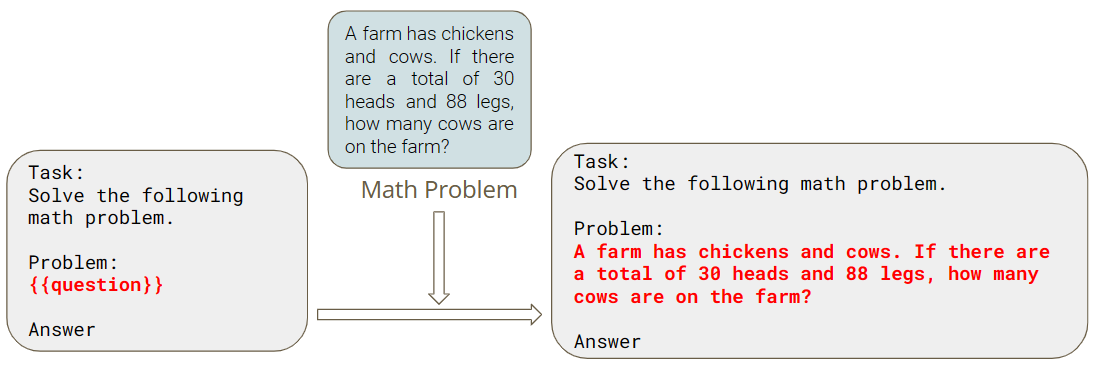
  - Maximum length: 1024 tokens
   

   

2. **Set Your Custom Prompt:**
   - Click `Set Prompt` to apply the content in `Prompt` as your custom prompt. Use `Clear Prompt` to clear any custom prompt you've entered.
   - After setting your prompt, you can check it in the `Log`.


3. **Evaluate Your Custom Prompt:**
   - Click `Evaluate` to evaluate your custom prompt with `Gemini` with the first `Number of examples used for evaluation` questions.
   - Your prompt will be evaluated three times per question.
   - The evaluation of all questions may take **20 to 30 minutes**, depending on the length of your prompt.

4. **Check out the result:**
    - Terminologies:
        - `Trial Number`: Range: `1∼3`, the evaluation runs 3 trials and vote for the final result.
        - `Question Number`: Range: `1∼n`, the first `n` questions used for the evaluation.
        
    - You can adjust the sliders to view the specific result.
    - It's recommended to adjust the slider click-by-click, since the slow reacting speed of the Gradio interface. If you want to quickly navigate to a number, inputting the number in the numeric input box guarantees the desired result.
    - The overall score is in `Result Stats`.

5. **Save Your Custom Prompt:**
   - Click `Save Custom Prompt` to save your results into a json file.

6. **Review the Process in `Log`:**
   - All operations are recorded in `Log`. Refer to it for process understanding or to replicate your experiment, though note some operations may introduce randomness.

### **Note**
- To insert a line break in the text box, use `Shift+Enter`.


<!-- * **Note: The first and the last line change tokens will be removed!** -->

In [ ]:
# Use gradio for custom prompt
# Integrated all following steps including assessing and downloading
import gradio as gr

def reset(chatbot):
    '''
    `Reset` btn click handler: reset prompt
    '''

    gr.Info("Clear prompt")

    chatbot.extend([["Clear Prompt", "Prompt successfully reset"]])
    return chatbot, "", 0

def assign(chatbot, prompt, template, Example_Number):
    '''
    `Assign` btn click handler: assign valid prompt and set up `template` state
    '''

    gr.Info("Assign prompt")


    #prompt = prompt.strip('\n')

    Example_Number = int(Example_Number)
    token_num = my_model.prompt_token_num(prompt)
    if token_num > 1024:
        #print("Invalid prompt")
        template = None
        gr.Warning("Invalid prompt (too long, >1024 tokens)")
        chatbot.append([None, "The prompt is too long (> 1024 tokens). A shorter prompt provides a faster and stabler assessment!"])
    elif Example_Number < 1 or Example_Number > len(questions):
        template = None
        prompt_ex = f"Error: Please select a number between 1 and {len(questions)}"
        gr.Warning(prompt_ex)
        chatbot.extend([[None, prompt_ex]])
    elif "{{question}}" not in prompt:
        template = None
        prompt_ex = "You need to put a placeholder {{question}} in your prompt."
        gr.Warning(prompt_ex)
        chatbot.extend([[None, prompt_ex]])
    else:
        environment = jinja2.Environment()
        template = environment.from_string(prompt)
        prompt_ex = f"""{template.render(question=questions[Example_Number - 1])}"""

        chatbot.extend([["Assign prompt", "Prompt successfully assigned\n\nCustom prompt demo:"], [None, prompt_ex]])

    return chatbot, prompt, template, Example_Number, token_num


# Refining the approach to handle multiple commas in large numbers while preserving commas between floats.
# The new strategy involves a more comprehensive pattern or possibly a different logic for processing the text.

# Adjusted strategy:
# 1. Identify all numeric sequences that might include commas and process each one individually.
# 2. For each sequence, determine if it represents a large number (with potential thousand separators) or a float.
# 3. Remove commas only from sequences identified as large numbers.

def clean_commas(text):
    # This function finds all numeric sequences that could include commas, decimal points, or be part of a float,
    # and then decides whether to remove commas based on the context.
    def process_match(match):
        number = match.group(0)
        # If the number is part of a float (has a decimal point), we'll return it unchanged.
        if '.' in number:
            return number
        # Otherwise, remove all commas, treating them as thousand separators.
        else:
          number_list = number.split(",")
          new_string = number_list[0]
          for i in range(1, len(number_list)):
            if len(number_list[i]) == 3:
              new_string += number_list[i]
            else:
              new_string += f",{number_list[i]}"
        return new_string

    # Regex explanation:
    # - \d+ matches one or more digits.
    # - (?:,\d+)* matches zero or more groups of a comma followed by one or more digits.
    # - (?:\.\d+)? optionally matches a decimal point followed by one or more digits, to catch floats.
    pattern = r'\d+(?:,\d+)*(?:\.\d+)?'
    return re.sub(pattern, process_match, text)


def find_and_match_floats(input_string, ground_truth):
  # Compile a regex pattern that matches floats and integers, including signed ones
  pattern = re.compile(r"[-+]?\d*\.\d+|[-+]?\d+")

  # Find all matches in the input string
  found_numbers = pattern.findall(input_string)

  # Convert found strings to floats
  found_floats = [float(num) for num in found_numbers]

  # Check if any of the found floats match the ground truth
  return ground_truth in found_floats

def assess(chatbot, template, test_num):
    '''
    `Test` btn click handler: test custom prompt by model (assess some examples)
    '''

    # Test if Gemini API key is valid
    # my_model = GeminiModel()
    # if not my_model.is_valid_key():
    #     chatbot.extend([[None, "Invalid API key"]])
    #     gr.Warning("Invalid API key")
    #     return chatbot, [], "Invalid API key. Make sure you set up your API key properly (at the beginning of the notebook).", gr.Slider(label="Result Number", value=0, minimum=0, maximum=0, step=1), gr.Textbox(label="Result", value="", interactive=False)

    # Make sure `template` state is valid
    if template is None:
        chatbot.extend([[None, "Test failed since empty template (i.e. invalid prompt)"]])
        gr.Warning("Prompt not set")
        return chatbot, [], "Prompt unset", gr.Slider(label="Result Number", value=0, minimum=0, maximum=0, step=1), gr.Textbox(label="Result", value="", interactive=False)

    gr.Info("Evaluate prompt")

    # Define the template for displaying results. This includes the question, rationale, and extracted answer.
    ans_template ="Prompt with Question:\n\n{{question}}\n\n--------------------\n\nProblem-solving Process:\n\n{{rationale}}\n\n--------------------\n\nFinal Answer\n\n{{answer}}"

    res_list = []
    total_count = test_num

    # Convert the ans_template string into a template object for rendering.
    environment = jinja2.Environment()
    ans_template = environment.from_string(ans_template)

    # Initialize counters for tracking the number of accurate responses.
    trial_num = 3
    trials = [[] for _ in range(trial_num)]
    res_stats_str = ""

    ## conduct three trials
    for i in range(trial_num):

        gr.Info(f"Start trial {i+1}")
        my_model.set_cache_file(f"gemini_cache_trial_{i+1}")
        accurate_count = 0

        # Iterate over each example in the examples list.
        for idx, example in enumerate(questions[:test_num]):
            test_res = ""

            result = my_model.two_stage_completion(example, template.render(question=example))

            ## check result['answer'] not None
            if not result["answer"]:
                trials[i].append(0)

                test_res += f"Trial {i+1}\n\n Skip question {idx + 1}."
                test_res += "\n" + "<"*6 + "="*30 + ">"*6 + "\n\n"
                res_list.append(f"Trial {i+1}\n\n Skip question {idx + 1}.")
                continue

            # Compare the model's answer with the ground truth and increment accurate_count if they match.

            # if str(answers[idx]) in result['answer']:
            #     accurate_count += 1
            #     trials[i].append(1)
            # else:
            #     trials[i].append(0)

            cleaned_result = clean_commas(result["answer"])
            if find_and_match_floats(cleaned_result, answers[idx]) or idx in [0, 26]:
              accurate_count += 1
              trials[i].append(1)
            else:
              trials[i].append(0)

            # Save the cache of the model's prompt and response.
            my_model.save_cache()

            test_res += f"Trial {i + 1}\n\n"
            test_res += f"Question {idx + 1}:\n" + '-'*20
            test_res += f'''\n\n{ans_template.render(question=result['prompt'], rationale=result['rationale'], answer=result['answer'])}\n'''
            test_res += "\n" + "<"*6 + "="*30 + ">"*6 + "\n\n"
            res_list.append(test_res)

            # time.sleep(1)


        # Print the accuracy statistics.
        res_stats_str += f"Trial {i + 1}, accurate_count: {accurate_count}, total_count: {total_count}, accuracy: {accurate_count / total_count * 100}%\n"
        # Save the cache of the model's prompt and response.
        my_model.save_cache()

    ## majority vote
    voting_acc = 0
    for i in range(total_count):
      count = 0
      for j in range(trial_num):
        if trials[j][i] == 1:
          count += 1
      if count >= 2:
        voting_acc += 1

    res_stats_str += f"Final Accuracy: {voting_acc / total_count * 100}%"

    # # Print the model's usage statistics from the cache.
    # usage_stats_str = str(my_model.cache_dict['usage'])

    chatbot.extend([["Test", "Test finished. The results can be find in \"Result\" and \"Result Stats\"."]])
    chatbot.extend([[None, "Test Result"], [None, ''.join(res_list)], [None, "Result Stats"], [None, res_stats_str]])
    return chatbot, res_list, res_stats_str, gr.Slider(label="Result Number", value=1, minimum=1, maximum=len(res_list), step=1, visible=False), gr.Textbox(label="Result", value=res_list[0], interactive=False)

def save_prompt(chatbot, prompt):
    '''
    `Save` btn click handler: save the prompt
    '''

    gr.Info("Save prompt")

    prompt_dict = {
        'prompt': prompt
    }

    # Dump the prompt into a JSON file.
    with open('prompt.json', 'w') as f:
        json.dump(prompt_dict, f)

    chatbot.extend([["Save prompt", f"Prompt saved as prompt.json"]])
    return chatbot

# Reference prompt
my_magic_prompt = "Task:\nSolve the following math problem.\n\nProblem: {{question}}\n\nAnswer:"


# Gradio UI
with gr.Blocks() as demo:
    my_magic_prompt = my_magic_prompt.strip('\n')
    template = gr.State(None)
    res_list = gr.State(list())

    # Components
    with gr.Tab(label="Console"):
        with gr.Group():
            example_num_box = gr.Dropdown(label="Demo Example (Please choose one example for demo)", value=1, info=questions[0], choices=[i+1 for i in range(len(questions))], filterable=False)
            prompt_textbox = gr.Textbox(label="Custom Prompt", placeholder=f"Enter your custom prompt here. For example:\n\n{my_magic_prompt}", value="", info="Make sure to include the `{{question}}` tag.")
            with gr.Row():
                set_button = gr.Button(value="Set Prompt")
                reset_button = gr.Button(value="Clear Prompt")
            prompt_token_num = gr.Textbox(label="Number of prompt tokens", value=0, interactive=False, info="The token number of the assigned custom prompt.")
        with gr.Group():
            test_num = gr.Slider(label="Number of examples used for evaluation", minimum=1, maximum=len(questions), step=1, value=1)
            assess_button = gr.Button(value="Evaluate")
        with gr.Group():
            with gr.Row():
                with gr.Column():
                    with gr.Row():
                        trial_no = gr.Slider(label="Trial ID", value=1, minimum=1, maximum=3, step=1)
                        ques_no = gr.Slider(label="Question ID", value=1, minimum=1, maximum=1, step=1)
                    res_num = gr.Slider(label="Result Number", value=0, minimum=0, maximum=0, step=1, visible=False)
                    res = gr.Textbox(label="Result", value="", placeholder="No result", interactive=False)
                with gr.Column():
                    res_stats = gr.Textbox(label="Result Stats", interactive=False)
            save_button = gr.Button(value="Save Custom Prompt")
    with gr.Tab(label="Log"):
        chatbot = gr.Chatbot(label="Log")

    # Event handlers
    example_num_box.input(lambda Example_Number: gr.Dropdown(label="Example (Please choose one example for demo)", value=Example_Number, info=questions[Example_Number - 1], choices=[i+1 for i in range(len(questions))]),
                inputs=[example_num_box],
                outputs=[example_num_box])
    res_num.change(lambda results, result_num, test_num: (gr.Textbox(label="Result", value=results[result_num-1], interactive=False) if len(results) != 0 else gr.Textbox(label="Result", value="", placeholder="No result", interactive=False),
                                    (int)((result_num-1)/test_num)+1,
                                    gr.Slider(label="Question Number", minimum=1, maximum=test_num, value=(result_num-1)%test_num+1, step=1)),
            inputs=[res_list, res_num, test_num],
            outputs=[res, trial_no, ques_no])
    trial_ques_no_input = lambda t_val, q_val, test_num: (t_val - 1) * test_num + q_val
    trial_no.input(trial_ques_no_input, inputs=[trial_no, ques_no, test_num], outputs=[res_num])
    ques_no.input(trial_ques_no_input, inputs=[trial_no, ques_no, test_num], outputs=[res_num])
    set_button.click(assign, inputs=[chatbot, prompt_textbox, template, example_num_box], outputs=[chatbot, prompt_textbox, template, example_num_box, prompt_token_num])
    reset_button.click(reset, inputs=[chatbot], outputs=[chatbot, prompt_textbox, prompt_token_num])
    assess_button.click(assess, inputs=[chatbot, template, test_num], outputs=[chatbot, res_list, res_stats, res_num, res])
    save_button.click(save_prompt, inputs=[chatbot, prompt_textbox], outputs=[chatbot])

demo.queue().launch(debug = True)


## 🧙 **Create Your Custom Prompt ( No-Gradio Version )**

---

This is the section without Gradio interface. In case the Gradio server has collapsed, you can use this section to do some basic prompt assignment and evaluation work.

### **Import required packages**

In [ ]:
import ipywidgets as widgets
from IPython.display import display

### **Set custom prompt**
1. Design your custom prompt in the text box. Note that the text box size can be adjusted as you prefer.
2. Click `Assign Prompt` to lock the input area (i.e. the text box) to prevent accidental and unnoticed change of the custom prompt.
3. For changing the custom prompt, click the `Clear Prompt` button to unlock the input area then go to 1.

In [ ]:
prompt_area = widgets.Textarea()
prompt_area_desc = widgets.HTML(value="<p>Custom Prompt:</p>")
setprompt_btn = widgets.Button(description="Assign Prompt")
resetprompt_btn = widgets.Button(description="Clear Prompt")
display_output = widgets.Output()
custom_prompt = ""

def set_prompt_clk(b):
  prompt_area.disabled = True
  print("Assign prompt")

def reset_prompt_clk(b):
  prompt_area.disabled = False
  prompt_area.value = ""
  print("Reset prompt")

setprompt_btn.on_click(set_prompt_clk)
resetprompt_btn.on_click(reset_prompt_clk)
display(prompt_area_desc, prompt_area, setprompt_btn, resetprompt_btn, display_output)

HTML(value='<p>Custom Prompt:</p>')

Textarea(value='')

Button(description='Set Prompt', style=ButtonStyle())

Button(description='Clear Prompt', style=ButtonStyle())

Output()

Assign prompt


4. Execute the cell to save the custom prompt above and to show a demo.

In [ ]:
custom_prompt = prompt_area.value
assert "{{question}}" in custom_prompt

#custom_prompt = "Task: {{question}}" # @param {type:"raw"}
Demo_Example = "7" # @param [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] {type:"string"}
demo_index = eval(Demo_Example)


environment = jinja2.Environment()
template = environment.from_string(custom_prompt)
print(f"Custom prompt demo:\n\n{template.render(question=questions[demo_index-1])}")

Custom prompt demo:

In a triangular garden bed, there are 16 plants along each side. Each plant requires a circular space with a radius of 0.5 meters to grow properly. Assuming plants are placed exactly next to each other, without overlapping, and maintaining a straight line from one corner of the triangular bed to the other, how much linear meter space is used by plants along one side of the garden bed?


### **Evaluation**
1. Select a `eval_num` which determines the number of examples to evaluate.
2. Execute the cell and wait for a noticeably long time depending on `eval_num` (up to 30 mins).

In [ ]:
eval_num = 9 # @param {type:"slider", min:1, max:30, step:1}
assert 1 <= eval_num <= 30

# Define the template for displaying results. This includes the question, rationale, and extracted answer.
ans_template ="Prompt with Question:\n\n{{question}}\n\n--------------------\n\nProblem-solving Process:\n\n{{rationale}}\n\n--------------------\n\nFinal Answer\n\n{{answer}}"

res_list = []
test_num = eval_num
total_count = test_num

# Convert the ans_template string into a template object for rendering.
environment = jinja2.Environment()
ans_template = environment.from_string(ans_template)

# Initialize counters for tracking the number of accurate responses.
trial_num = 3
trials = [[] for _ in range(trial_num)]
res_stats_str = ""

## conduct three trials


def clean_commas(text):
    # This function finds all numeric sequences that could include commas, decimal points, or be part of a float,
    # and then decides whether to remove commas based on the context.
    def process_match(match):
        number = match.group(0)
        # If the number is part of a float (has a decimal point), we'll return it unchanged.
        if '.' in number:
            return number
        # Otherwise, remove all commas, treating them as thousand separators.
        else:
          number_list = number.split(",")
          new_string = number_list[0]
          for i in range(1, len(number_list)):
            if len(number_list[i]) == 3:
              new_string += number_list[i]
            else:
              new_string += f",{number_list[i]}"
        return new_string

    # Regex explanation:
    # - \d+ matches one or more digits.
    # - (?:,\d+)* matches zero or more groups of a comma followed by one or more digits.
    # - (?:\.\d+)? optionally matches a decimal point followed by one or more digits, to catch floats.
    pattern = r'\d+(?:,\d+)*(?:\.\d+)?'
    return re.sub(pattern, process_match, text)


def find_and_match_floats(input_string, ground_truth):
    # Compile a regex pattern that matches floats and integers, including signed ones
    pattern = re.compile(r"[-+]?\d*\.\d+|[-+]?\d+")

    # Find all matches in the input string
    found_numbers = pattern.findall(input_string)

    # Convert found strings to floats
    found_floats = [float(num) for num in found_numbers]

    # Check if any of the found floats match the ground truth
    return ground_truth in found_floats

for i in range(trial_num):

    print(f"Start trial {i+1}")
    # res_list.append(f"Start trial {i+1}")
    # my_model = GeminiModel(cache_file=f"gemini_cache_trial_{i+1}")
    # my_model.cache_file = f"gemini_cache_trial_{i+1}"
    # my_model.load_cache()
    my_model.set_cache_file(f"gemini_cache_trial_{i+1}")
    accurate_count = 0

    # Iterate over each example in the examples list.
    for idx, example in enumerate(questions[:test_num]):
        test_res = ""

        result = my_model.two_stage_completion(example, template.render(question=example))

        ## check result['answer'] not None
        if not result["answer"]:
            trials[i].append(0)

            test_res += f"Trial {i+1}\n\n Skip question {idx + 1}."
            test_res += "\n" + "<"*6 + "="*30 + ">"*6 + "\n\n"
            res_list.append(f"Trial {i+1}\n\n Skip question {idx + 1}.")
            continue

        # Compare the model's answer with the ground truth and increment accurate_count if they match.

        cleaned_result = clean_commas(result["answer"])
        if find_and_match_floats(cleaned_result, answers[idx]) or idx in [0, 26]:
          accurate_count += 1
          trials[i].append(1)
        else:
          trials[i].append(0)

        # Save the cache of the model's prompt and response.
        my_model.save_cache()

        test_res += f"Trial {i + 1}\n\n"
        test_res += f"Question {idx + 1}:\n" + '-'*20
        test_res += f'''\n\n{ans_template.render(question=result['prompt'], rationale=result['rationale'], answer=result['answer'])}\n'''
        test_res += "\n" + "<"*6 + "="*30 + ">"*6 + "\n\n"
        res_list.append(test_res)

        time.sleep(1)


    # Print the accuracy statistics.
    res_stats_str += f"Trial {i + 1}, accurate_count: {accurate_count}, total_count: {total_count}, accuracy: {accurate_count / total_count * 100}%\n"
    # Save the cache of the model's prompt and response.
    my_model.save_cache()

## majority vote
voting_acc = 0
for i in range(total_count):
    count = 0
    for j in range(trial_num):
        if trials[j][i] == 1:
            count += 1
    if count >= 2:
        voting_acc += 1

res_stats_str += f"Final Accuracy: {voting_acc / total_count * 100}%"


print(f"Final accuracy: {res_stats_str}")

### **Print a specific evaluated question**
1. Choose the `trial_id` and `question_id` that you want to print.
2. Execute the cell.

In [ ]:
trial_id = 3 # @param {type:"integer"}
question_id = 1 # @param {type:"integer"}

if trial_id not in [1,2,3]:
  print("trial_id can only be 1, 2 or 3.")
elif question_id not in [i for i in range(1, eval_num + 1)]:
  print(f"question_id can only be 1 to {eval_num}")
else:
  print(f"The evaluation result of question {question_id} in the No.{trial_id} trial is:\n{res_list[(trial_id-1) * eval_num + question_id - 1]}")




### **Save Prompt**  
Execute the cell to save the prompt as json file in Colab.

In [ ]:
prompt_dict = {
    'prompt': custom_prompt
}

# Dump the prompt into a JSON file.
with open('prompt.json', 'w') as f:
    json.dump(prompt_dict, f)

print("Prompt saved as prompt.json")

## ⬇ Download your prompt
- Be sure you have saved your prompt !!
- This block will automatically download the file named `prompt.json`, containing the **last prompt** you have saved.

### Note
- If you want to use this block to download your prompt, make sure you have stopped the Gradio.

In [ ]:
# Download the json file.
from google.colab import files
files.download(f'prompt.json')
print(f"Download prompt.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download prompt.json
